CSV MLR ANALYSIS:

/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_955/459439640.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Rows before drop: 2004
Rows after drop: 2004
Any NaNs in continuous vars: wait_time_s       True
accepted_gap_s    True
leg_distance      True
dtype: bool

Dropping 19 rows with missing or infinite predictor values:
      const  Gender  Using Phone  two_stage_crossing  Accuator  \
442     1.0     1.0          0.0                 0.0       0.0   
791     1.0     0.0          0.0                 0.0       1.0   
792     1.0     0.0          0.0                 0.0       1.0   
795     1.0     0.0          0.0                 0.0       0.0   
796     1.0     0.0          0.0                 0.0       0.0   
1113    1.0     0.0          0.0                 0.0       1.0   
1114    1.0     0.0          1.0                 0.0       1.0   
1115    1.0     0.0          0.0                 0.0       1.0   
1479    1.0     0.0          0.0                 0.0       1.0   
1480    1.0     1.0          1.0                 0.0       0.0   
1481    1.0     1.0          1.0                 1.0      

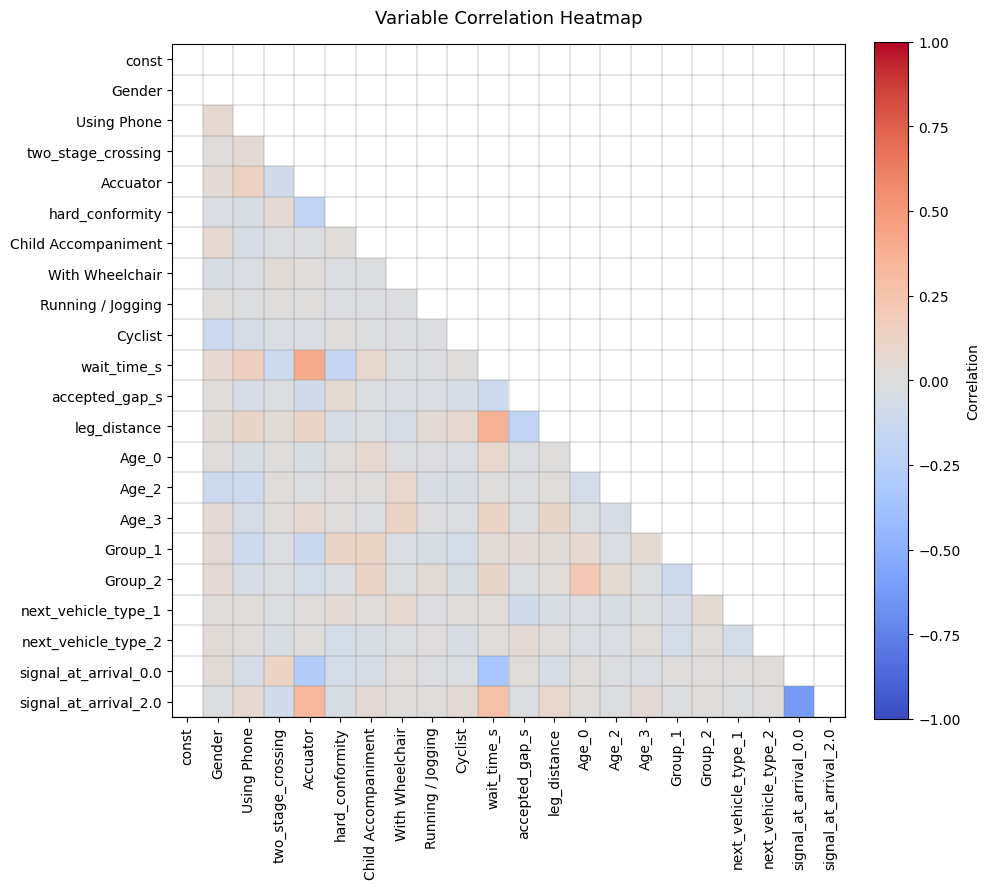

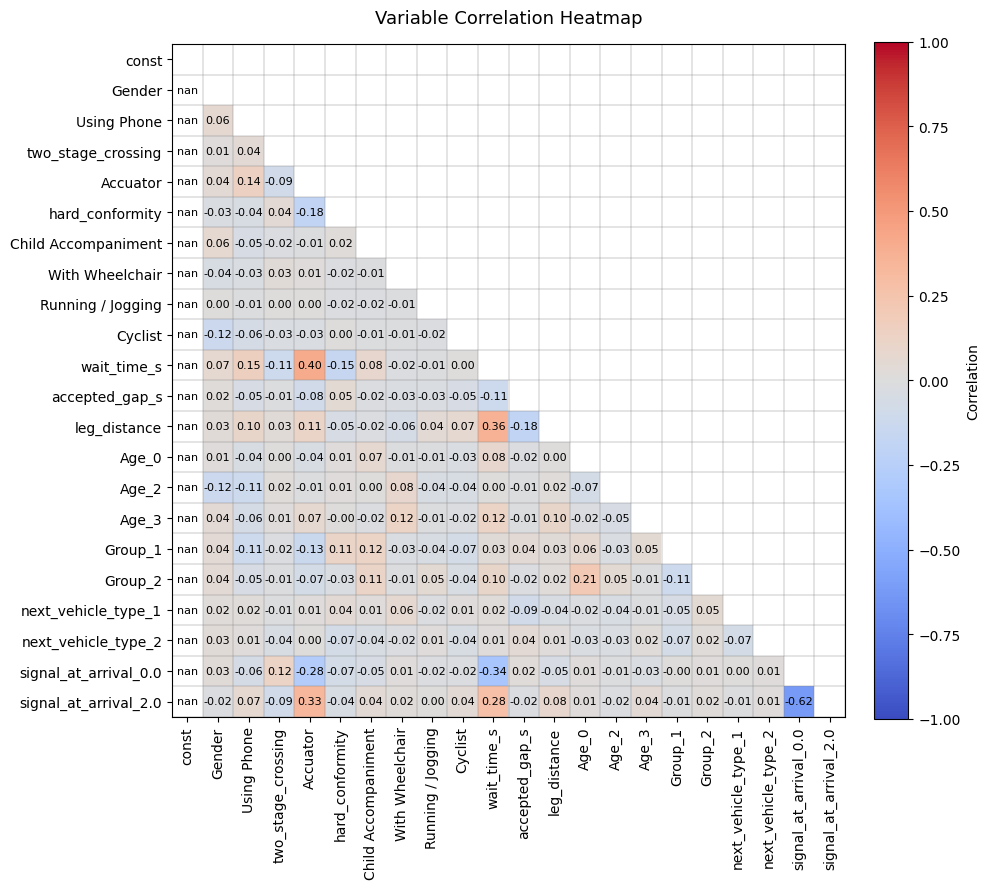


No strong correlations (|r| > 0.7) found among predictors.

===== Top 10 Positive Correlations =====
Accuator            wait_time_s              0.40
wait_time_s         leg_distance             0.36
Accuator            signal_at_arrival_2.0    0.33
wait_time_s         signal_at_arrival_2.0    0.28
Age_0               Group_2                  0.21
Using Phone         wait_time_s              0.15
                    Accuator                 0.14
two_stage_crossing  signal_at_arrival_0.0    0.12
Accuator            leg_distance             0.11
Using Phone         leg_distance             0.10
dtype: float64

===== Top 10 Negative Correlations =====
two_stage_crossing     Accuator                -0.09
Using Phone            Age_2                   -0.11
Gender                 Cyclist                 -0.12
Accuator               Group_1                 -0.13
hard_conformity        wait_time_s             -0.15
Accuator               hard_conformity         -0.18
                       

In [1]:
# new csv files - hard compliance
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt


# ===================== 1. Load dataset =====================
df = pd.read_csv(
    '/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_HARD_COMPLIANCE.csv',
    header=0
)

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Strip spaces from string entries (if any)
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# ===================== 2. Define variables =====================
binary_cols = [
    'Gender', 'Using Phone', 
    'two_stage_crossing', 
    'Accuator', 'hard_conformity', 
    'Child Accompaniment',
    'With Wheelchair', 
    # 'With Pram', 
    'Running / Jogging', 'Cyclist',
    # 'Pet Accompaniment'
]

multi_cols = ['Age', 'Group', 'Session', 'next_vehicle_type',
               'signal_at_arrival'
               ]  # Multi-category
continuous_cols = ['wait_time_s', 'accepted_gap_s', 'leg_distance', 
                #    'time_to_next_vehicle_s'
                   ]

dependent_var = 'hard_compliance'

# ===================== 3. Convert columns to numeric =====================
all_cols = binary_cols + multi_cols + continuous_cols + [dependent_var]
df = df[all_cols].copy()
for col in all_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# ===================== 4. Prepare predictors and outcome =====================
y = df[dependent_var].astype(float)
X = df[binary_cols + multi_cols + continuous_cols]

# One-hot encode multi-category variables
X = pd.get_dummies(X, columns=multi_cols, drop_first=True)
# ---------------- Explicit Reference Categories ----------------
# Define reference categories for each multi-category variable
reference_categories = {
    'Age': '1',              # Age_1 as reference
    'Group': '0',            # Group_0 as reference
    'next_vehicle_type': '0',# next_vehicle_type_0 as reference
    'signal_at_arrival': '1.0', # FR signal as reference
}

# One-hot encode multi-category variables without dropping any
X = pd.get_dummies(df[binary_cols + multi_cols + continuous_cols], columns=multi_cols, drop_first=False)

# Drop explicit reference columns
for var, ref_cat in reference_categories.items():
    col_name = f"{var}_{ref_cat}"
    if col_name in X.columns:
        X = X.drop(columns=[col_name])


# Standardize continuous variables
scaler = StandardScaler()
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])

# Ensure all columns are float
X = X.astype(float)

# Add constant for intercept
X = sm.add_constant(X)

print("Rows before drop:", len(df))
print("Rows after drop:", len(df))
print("Any NaNs in continuous vars:", df[continuous_cols].isna().any())


# ===================== CLEANUP BEFORE REGRESSION =====================
# 1. Replace infinities with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# 2. Drop any rows that have missing predictor data
bad_rows = X[X.isna().any(axis=1)]
if not bad_rows.empty:
    print(f"\nDropping {len(bad_rows)} rows with missing or infinite predictor values:")
    print(bad_rows)
    X = X.dropna()
    y = y.loc[X.index]  # realign y

# 3. Final diagnostic
print("\nFinal check before model:")
print("Any NaNs left in X?", X.isna().any().any())
print("Any inf values in X?", np.isinf(X.to_numpy()).any())
print("X shape:", X.shape, "| y shape:", y.shape)


# Compute VIF for each predictor
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort and print
print("\n================ Variance Inflation Factors (VIF) ================")
print(vif.sort_values(by="VIF", ascending=False))

# ===================== 5. Fit logistic regression =====================
logit_model = sm.Logit(y, X)
# result = logit_model.fit(disp=False)
result = logit_model.fit(method='lbfgs', maxiter=1000, disp=True)

# ===================== 6. Create odds ratio table =====================
odds_ratios = pd.DataFrame({
    'Variable': result.params.index,
    'Coefficient': result.params.values,
    'Odds Ratio': np.exp(result.params.values),
    'Std Err': result.bse.values,
    'z-value': result.tvalues,
    'p-value': result.pvalues,
    'CI 2.5%': result.conf_int()[0],
    'CI 97.5%': result.conf_int()[1]
})

# Add significance column
odds_ratios['Significant'] = odds_ratios['p-value'].apply(lambda p: 'Yes' if p < 0.05 else 'No')

# Sort by p-value
odds_ratios = odds_ratios.sort_values(by='p-value')

# ===================== 6b. Add readable interpretation =====================
odds_ratios['Odds % Change'] = (odds_ratios['Odds Ratio'] - 1) * 100
odds_ratios['Interpretation'] = odds_ratios['Odds % Change'].apply(
    lambda x: f"Increases odds by {x:.1f}%" if x > 0 else f"Decreases odds by {abs(x):.1f}%"
)

# ===================== 7. Print results =====================
print("\n================ Logistic Regression Odds Ratios ================")
print(odds_ratios.to_string(index=False))

print("\n================ Full Logistic Regression Summary ================")
print(result.summary())

# ===================== CORRELATION + MULTICOLLINEARITY DIAGNOSTICS =====================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========== Correlation Matrix ==========
print("\n================ Correlation Matrix (All Variables) ================")
corr_matrix = X.corr().round(2)
print(corr_matrix)

# ========== Mask upper triangle ==========
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # mask upper triangle

# ========== Plot Heatmap (Lower Triangle Only) ==========
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(np.where(mask, np.nan, corr_matrix), cmap='coolwarm', vmin=-1, vmax=1)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation')

# Axis labels
ax.set_xticks(range(len(corr_matrix)))
ax.set_yticks(range(len(corr_matrix)))
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticklabels(corr_matrix.columns)
ax.set_title("Variable Correlation Heatmap", fontsize=13, pad=15)

# Gridlines for clarity
ax.set_xticks(np.arange(-.5, len(corr_matrix), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(corr_matrix), 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.3)
ax.tick_params(which="minor", bottom=False, left=False)

plt.tight_layout()
plt.show()


# Assuming corr_matrix is your correlation matrix
fig, ax = plt.subplots(figsize=(10, 10))

# Mask upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap with colors
im = ax.imshow(np.where(mask, np.nan, corr_matrix), cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation')

# Axis labels
ax.set_xticks(range(len(corr_matrix)))
ax.set_yticks(range(len(corr_matrix)))
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticklabels(corr_matrix.columns)
ax.set_title("Variable Correlation Heatmap", fontsize=13, pad=15)

# Gridlines for clarity
ax.set_xticks(np.arange(-.5, len(corr_matrix), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(corr_matrix), 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.3)
ax.tick_params(which="minor", bottom=False, left=False)

# ===== Add correlation values in each cell =====
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        if i < j:  # only annotate lower triangle (or flip i>j)
            continue
        if mask[i, j]:
            continue
        value = corr_matrix.iloc[i, j]
        ax.text(j, i, f"{value:.2f}", ha='center', va='center', color='black', fontsize=8)

plt.tight_layout()
plt.show()

# -------- Identify highly correlated pairs --------
corr_pairs = (
    corr_matrix.unstack()
    .drop_duplicates()
    .sort_values(ascending=False)
)
corr_pairs = corr_pairs[(corr_pairs < 0.999) & (corr_pairs.abs() > 0.7)]
if corr_pairs.empty:
    print("\nNo strong correlations (|r| > 0.7) found among predictors.")
else:
    print("\n================ Highly Correlated Variable Pairs (|r| > 0.7) ================")
    print(corr_pairs)

# Assuming `corr_matrix` is your Pearson correlation matrix
# Remove duplicates and self-correlations (1.0 on diagonal)
corr_pairs = corr_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
corr_pairs = corr_pairs.drop_duplicates()

# Sort correlations
sorted_corr = corr_pairs.sort_values(ascending=False)

# Top 10 positive correlations
top_pos = sorted_corr.head(10)

# Top 10 negative correlations
top_neg = sorted_corr.tail(10)

print("\n===== Top 10 Positive Correlations =====")
print(top_pos)

print("\n===== Top 10 Negative Correlations =====")
print(top_neg)

# -------- Interpretation summary --------
print("""
Interpretation Guide:
- |r| > 0.7  → strong correlation, possible redundancy.
- VIF < 5    → safe
- VIF 5–10   → moderate multicollinearity, check variables
- VIF > 10   → severe multicollinearity, consider removing or combining predictors
""")

# ===================== Print Logistic Regression Equation =====================
import numpy as np

# Get the variable names and coefficients
variables = result.params.index
coefficients = result.params.values

# Build the linear predictor equation
terms = []
for var, coef in zip(variables, coefficients):
    # Format coefficient with 3 decimals
    coef_str = f"{coef:.3f}"
    # Add "+" for positive coefficients except for the first (intercept)
    if var != 'const' and coef >= 0:
        coef_str = "+ " + coef_str
    elif var != 'const' and coef < 0:
        coef_str = "- " + str(abs(coef))
    terms.append(f"{coef_str}*{var}" if var != 'const' else coef_str)

# Join all terms
equation = " + ".join([t for t in terms if t])

print("\n================ Logistic Regression Equation =================")
print("logit(p) =", equation)

# Optionally, show probability form
print("\nProbability form:")
print("p = 1 / (1 + exp(-logit(p)))")

/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_45033/260461830.py:20: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Rows before drop: 2004
Rows after drop: 2004
Any NaNs in continuous vars: wait_time_s    True
dtype: bool

Dropping 2 rows with missing or infinite predictor values:
      const  Gender  Using Phone  Accuator  hard_conformity  wait_time_s  \
795     1.0     0.0          0.0       0.0              0.0          NaN   
1905    1.0     1.0          0.0       0.0              0.0          NaN   

      Group_1  Group_2  signal_at_arrival_0.0  signal_at_arrival_2.0  
795       0.0      0.0                    0.0                    0.0  
1905      1.0      0.0                    1.0                    0.0  

Final check before model:
Any NaNs left in X? False
Any inf values in X? False
X shape: (2002, 10) | y shape: (2002,)

================ Variance Inflation Factors (VIF) ================
                Variable       VIF
0                  const  7.563952
8  signal_at_arrival_0.0  1.772349
9  signal_at_arrival_2.0  1.716341
3               Accuator  1.362651
5            wait_time_s  1.35

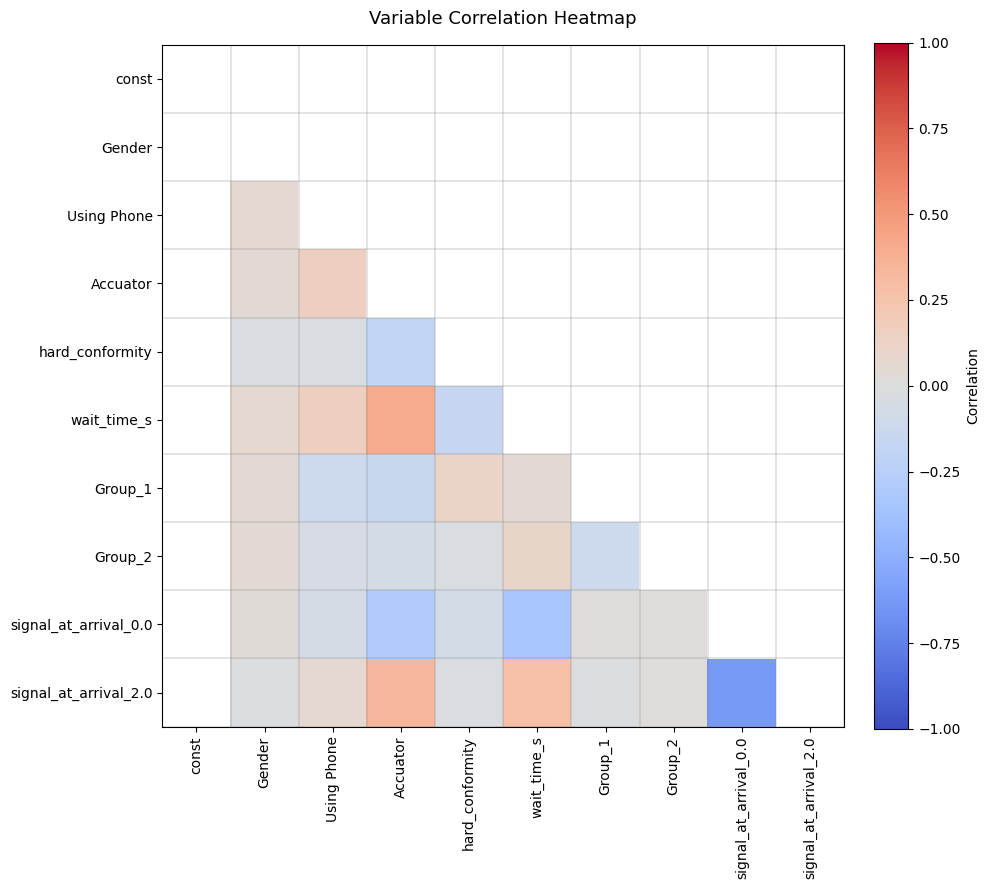


No strong correlations (|r| > 0.7) found among predictors.

===== Top 10 Positive Correlations =====
Accuator         wait_time_s              0.40
                 signal_at_arrival_2.0    0.33
wait_time_s      signal_at_arrival_2.0    0.28
Using Phone      Accuator                 0.15
hard_conformity  Group_1                  0.11
wait_time_s      Group_2                  0.10
Gender           wait_time_s              0.07
                 Using Phone              0.06
                 Accuator                 0.04
                 signal_at_arrival_0.0    0.03
dtype: float64

===== Top 10 Negative Correlations =====
Using Phone            signal_at_arrival_0.0   -0.06
Accuator               Group_2                 -0.07
Using Phone            Group_1                 -0.11
Accuator               Group_1                 -0.14
hard_conformity        wait_time_s             -0.15
Accuator               hard_conformity         -0.18
                       signal_at_arrival_0.0   -0.29


In [ ]:
# new csv files - hard compliance - only significant variables
import pandas as pd
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt


# ===================== 1. Load dataset =====================
df = pd.read_csv(
    '/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/REGRESSION_SINGLE_HARD_COMPLIANCE.csv',
    header=0
)

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Strip spaces from string entries (if any)
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# ===================== 2. Define variables =====================
binary_cols = [
    'Gender', 
    'Using Phone', 
    # 'two_stage_crossing', 
    'Accuator', 
    'hard_conformity', 
    # 'Child Accompaniment',
    # 'With Wheelchair', 
    # 'With Pram', 
    # 'Running / Jogging', 
    # 'Cyclist',
    # 'Pet Accompaniment'
]

multi_cols = [
            # 'Age', 
            'Group', 
            # 'Session', 
            # 'next_vehicle_type',
               'signal_at_arrival'
               ]  
continuous_cols = ['wait_time_s', 
                #    'accepted_gap_s', 
                   'leg_distance', 
                #    'time_to_next_vehicle_s'
                   ]

dependent_var = 'hard_compliance'

# ===================== 3. Convert columns to numeric =====================
all_cols = binary_cols + multi_cols + continuous_cols + [dependent_var]
df = df[all_cols].copy()
for col in all_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# ===================== 4. Prepare predictors and outcome =====================
y = df[dependent_var].astype(float)
X = df[binary_cols + multi_cols + continuous_cols]

# One-hot encode multi-category variables
X = pd.get_dummies(X, columns=multi_cols, drop_first=True)
# ---------------- Explicit Reference Categories ----------------
# Define reference categories for each multi-category variable
reference_categories = {
    'Age': '1',              # Age_1 as reference
    'Group': '0',            # Group_0 as reference
    'next_vehicle_type': '0',# next_vehicle_type_0 as reference
    'signal_at_arrival': '1.0', # FR signal as reference
}

# One-hot encode multi-category variables without dropping any
X = pd.get_dummies(df[binary_cols + multi_cols + continuous_cols], columns=multi_cols, drop_first=False)

# Drop explicit reference columns
for var, ref_cat in reference_categories.items():
    col_name = f"{var}_{ref_cat}"
    if col_name in X.columns:
        X = X.drop(columns=[col_name])


# Standardize continuous variables
scaler = StandardScaler()
X[continuous_cols] = scaler.fit_transform(X[continuous_cols])

# Ensure all columns are float
X = X.astype(float)

# Add constant for intercept
X = sm.add_constant(X)

print("Rows before drop:", len(df))
print("Rows after drop:", len(df))
print("Any NaNs in continuous vars:", df[continuous_cols].isna().any())


# ===================== CLEANUP BEFORE REGRESSION =====================
# 1. Replace infinities with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# 2. Drop any rows that have missing predictor data
bad_rows = X[X.isna().any(axis=1)]
if not bad_rows.empty:
    print(f"\nDropping {len(bad_rows)} rows with missing or infinite predictor values:")
    print(bad_rows)
    X = X.dropna()
    y = y.loc[X.index]  # realign y

# 3. Final diagnostic
print("\nFinal check before model:")
print("Any NaNs left in X?", X.isna().any().any())
print("Any inf values in X?", np.isinf(X.to_numpy()).any())
print("X shape:", X.shape, "| y shape:", y.shape)


# Compute VIF for each predictor
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort and print
print("\n================ Variance Inflation Factors (VIF) ================")
print(vif.sort_values(by="VIF", ascending=False))

# ===================== 5. Fit logistic regression =====================
logit_model = sm.Logit(y, X)
# result = logit_model.fit(disp=False)
result = logit_model.fit(method='lbfgs', maxiter=1000, disp=True)

# ===================== 6. Create odds ratio table =====================
odds_ratios = pd.DataFrame({
    'Variable': result.params.index,
    'Coefficient': result.params.values,
    'Odds Ratio': np.exp(result.params.values),
    'Std Err': result.bse.values,
    'z-value': result.tvalues,
    'p-value': result.pvalues,
    'CI 2.5%': result.conf_int()[0],
    'CI 97.5%': result.conf_int()[1]
})

# Add significance column
odds_ratios['Significant'] = odds_ratios['p-value'].apply(lambda p: 'Yes' if p < 0.05 else 'No')

# Sort by p-value
odds_ratios = odds_ratios.sort_values(by='p-value')

# ===================== 6b. Add readable interpretation =====================
odds_ratios['Odds % Change'] = (odds_ratios['Odds Ratio'] - 1) * 100
odds_ratios['Interpretation'] = odds_ratios['Odds % Change'].apply(
    lambda x: f"Increases odds by {x:.1f}%" if x > 0 else f"Decreases odds by {abs(x):.1f}%"
)

# ===================== 7. Print results =====================
print("\n================ Logistic Regression Odds Ratios ================")
print(odds_ratios.to_string(index=False))

print("\n================ Full Logistic Regression Summary ================")
print(result.summary())

# ===================== CORRELATION + MULTICOLLINEARITY DIAGNOSTICS =====================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========== Correlation Matrix ==========
print("\n================ Correlation Matrix (All Variables) ================")
corr_matrix = X.corr().round(2)
print(corr_matrix)

# ========== Mask upper triangle ==========
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # mask upper triangle

# ========== Plot Heatmap (Lower Triangle Only) ==========
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(np.where(mask, np.nan, corr_matrix), cmap='coolwarm', vmin=-1, vmax=1)

# Colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation')

# Axis labels
ax.set_xticks(range(len(corr_matrix)))
ax.set_yticks(range(len(corr_matrix)))
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticklabels(corr_matrix.columns)
ax.set_title("Variable Correlation Heatmap", fontsize=13, pad=15)

# Gridlines for clarity
ax.set_xticks(np.arange(-.5, len(corr_matrix), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(corr_matrix), 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.3)
ax.tick_params(which="minor", bottom=False, left=False)

plt.tight_layout()
plt.show()


# -------- Identify highly correlated pairs --------
corr_pairs = (
    corr_matrix.unstack()
    .drop_duplicates()
    .sort_values(ascending=False)
)
corr_pairs = corr_pairs[(corr_pairs < 0.999) & (corr_pairs.abs() > 0.7)]
if corr_pairs.empty:
    print("\nNo strong correlations (|r| > 0.7) found among predictors.")
else:
    print("\n================ Highly Correlated Variable Pairs (|r| > 0.7) ================")
    print(corr_pairs)

# Assuming `corr_matrix` is your Pearson correlation matrix
# Remove duplicates and self-correlations (1.0 on diagonal)
corr_pairs = corr_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
corr_pairs = corr_pairs.drop_duplicates()

# Sort correlations
sorted_corr = corr_pairs.sort_values(ascending=False)

# Top 10 positive correlations
top_pos = sorted_corr.head(10)

# Top 10 negative correlations
top_neg = sorted_corr.tail(10)

print("\n===== Top 10 Positive Correlations =====")
print(top_pos)

print("\n===== Top 10 Negative Correlations =====")
print(top_neg)

# -------- Interpretation summary --------
print("""
Interpretation Guide:
- |r| > 0.7  → strong correlation, possible redundancy.
- VIF < 5    → safe
- VIF 5–10   → moderate multicollinearity, check variables
- VIF > 10   → severe multicollinearity, consider removing or combining predictors
""")

# ===================== Print Logistic Regression Equation =====================
import numpy as np

# Get the variable names and coefficients
variables = result.params.index
coefficients = result.params.values

# Build the linear predictor equation
terms = []
for var, coef in zip(variables, coefficients):
    # Format coefficient with 3 decimals
    coef_str = f"{coef:.3f}"
    # Add "+" for positive coefficients except for the first (intercept)
    if var != 'const' and coef >= 0:
        coef_str = "+ " + coef_str
    elif var != 'const' and coef < 0:
        coef_str = "- " + str(abs(coef))
    terms.append(f"{coef_str}*{var}" if var != 'const' else coef_str)

# Join all terms
equation = " + ".join([t for t in terms if t])

print("\n================ Logistic Regression Equation =================")
print("logit(p) =", equation)

# Optionally, show probability form
print("\nProbability form:")
print("p = 1 / (1 + exp(-logit(p)))")

Hazard Models:

/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_23983/3049115109.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


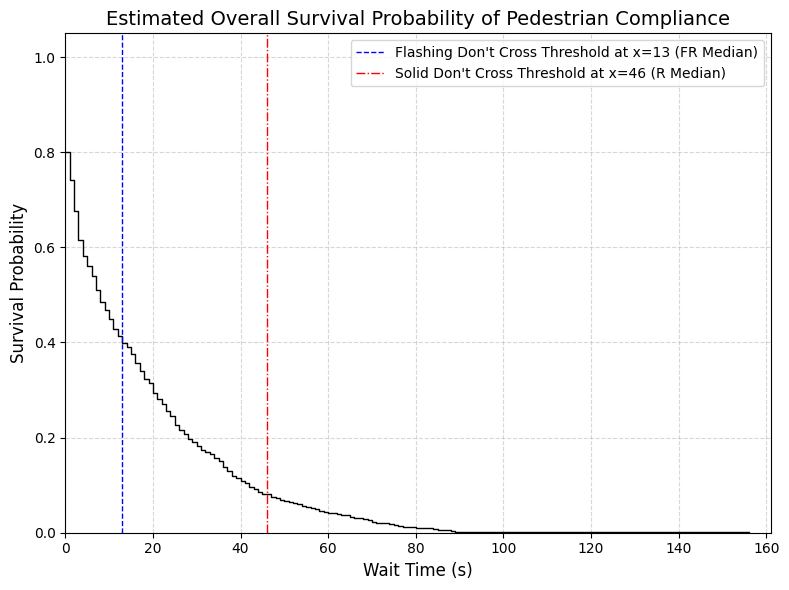

Estimated overall survival probability of compliance: 0.00


In [15]:
# ===================== IMPORTS =====================
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# ===================== LOAD DATA =====================
FILE_PATH = '/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/HAZARD_SINGLE_HARD_COMPLIANCE.csv'
df = pd.read_csv(FILE_PATH)

# Clean column names and string entries
df.columns = df.columns.str.strip()
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Ensure numeric columns
df['wait_time_s'] = pd.to_numeric(df['wait_time_s'], errors='coerce')
df['hard_compliance'] = pd.to_numeric(df['hard_compliance'], errors='coerce')

# Drop rows with missing values in key columns
df = df.dropna(subset=['wait_time_s', 'hard_compliance'])

# ===================== DEFINE EVENT =====================
# Event = pedestrian starts crossing (non-compliance)
df['Event'] = 1  # Assuming all pedestrians eventually cross

# ===================== FIT KAPLAN-MEIER MODEL =====================
kmf = KaplanMeierFitter()
kmf.fit(durations=df['wait_time_s'], event_observed=df['Event'])

# ===================== PLOT CUMULATIVE RISK =====================
plt.figure(figsize=(8,6))
# survival probability (compliance)
plt.step(kmf.timeline, kmf.survival_function_['KM_estimate'], where="post", color='black', linewidth=1)

#plot waiting thresholds
plt.axvline(x=13, color='blue', linestyle='--', linewidth=1, label='Flashing Don\'t Cross Threshold at x=13 (FR Median)') #plot median FR time
plt.axvline(x=46, color='red', linestyle='-.', linewidth=1, label='Solid Don\'t Cross Threshold at x=46 (R Median)') #plot median R time


plt.xlabel("Wait Time (s)", fontsize=12)
# plt.ylabel("Cumulative Risk of Non-Compliance", fontsize=12)
plt.legend()
plt.ylabel("Survival Probability", fontsize=12)
plt.title("Estimated Overall Survival Probability of Pedestrian Compliance", fontsize=14)
plt.xlim(0, df['wait_time_s'].max()+5)
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ===================== OPTIONAL: SUMMARY STATISTICS =====================
overall_risk = kmf.survival_function_.iloc[-1,0]
print(f"Estimated overall survival probability of compliance: {overall_risk:.2f}")


/var/folders/1g/kfv0kct16s1gdd4k7rzps5tr0000gn/T/ipykernel_955/2668339198.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


<lifelines.CoxPHFitter: fitted with 1985 total observations, 0 right-censored observations>
             duration col = 'wait_time_s'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 1985
number of events observed = 1985
   partial log-likelihood = -12564.04
         time fit was run = 2025-11-12 09:17:18 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
Age                  0.02      1.02      0.05           -0.08            0.11                0.93                1.12
Gender              -0.07      0.93      0.05           -0.16            0.02                0.85                1.02
Group               -0.42      0.66      0.05           -0.51           -0.33                0.60                0.72
Child Accompaniment -0.26      0.77      0.14           -0.54            0.01                0.59                1.01
Using Phone         -0.26      0.77      0.06           -0.38           -0.13                0.68                0.87
two_stage_crossing   0.29      1.34      0.07            0.15            0.43                1.17                1.54
Running / Jogging    0.65      1.92      0.25            0.17            1.14                1.19                3.11
Cyclist              0.18      1.19      0.13           -0.09            0.44                0.92                1.55
With Wheelchair     -0.15      0.86      0.36           -0.86            0.55                0.42                1.73
Pet Accompaniment   -0.01      0.99      0.12           -0.25            0.23                0.78                1.26
hard_conformity      0.48      1.61      0.07            0.33            0.62                1.40                1.87
next_vehicle_type   -0.02      0.98      0.02           -0.06            0.02                0.94                1.02
accepted_gap_s       0.00      1.00      0.00           -0.00            0.00                1.00                1.00
leg_distance        -0.13      0.87      0.01           -0.15           -0.12                0.86                0.89
signal_at_arrival   -0.61      0.55      0.03           -0.67           -0.54                0.51                0.58
Accuator            -0.76      0.47      0.05           -0.86           -0.65                0.43                0.52

                     cmp to      z      p  -log2(p)
covariate                                          
Age                    0.00   0.37   0.71      0.50
Gender                 0.00  -1.50   0.13      2.89
Group                  0.00  -9.16 <0.005     64.09
Child Accompaniment    0.00  -1.92   0.06      4.17
Using Phone            0.00  -4.08 <0.005     14.43
two_stage_crossing     0.00   4.10 <0.005     14.58
Running / Jogging      0.00   2.67   0.01      7.04
Cyclist                0.00   1.31   0.19      2.39
With Wheelchair        0.00  -0.43   0.67      0.59
Pet Accompaniment      0.00  -0.08   0.93      0.10
hard_conformity        0.00   6.46 <0.005     33.15
next_vehicle_type      0.00  -1.14   0.25      1.98
accepted_gap_s         0.00   0.47   0.64      0.65
leg_distance           0.00 -14.78 <0.005    161.80
signal_at_arrival      0.00 -17.92 <0.005    236.23
Accuator               0.00 -14.75 <0.005    161.08
---
Concordance = 0.77
Partial AIC = 25160.07
log-likelihood ratio test = 1057.05 on 16 df
-log2(p) of ll-ratio test = 711.46

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")


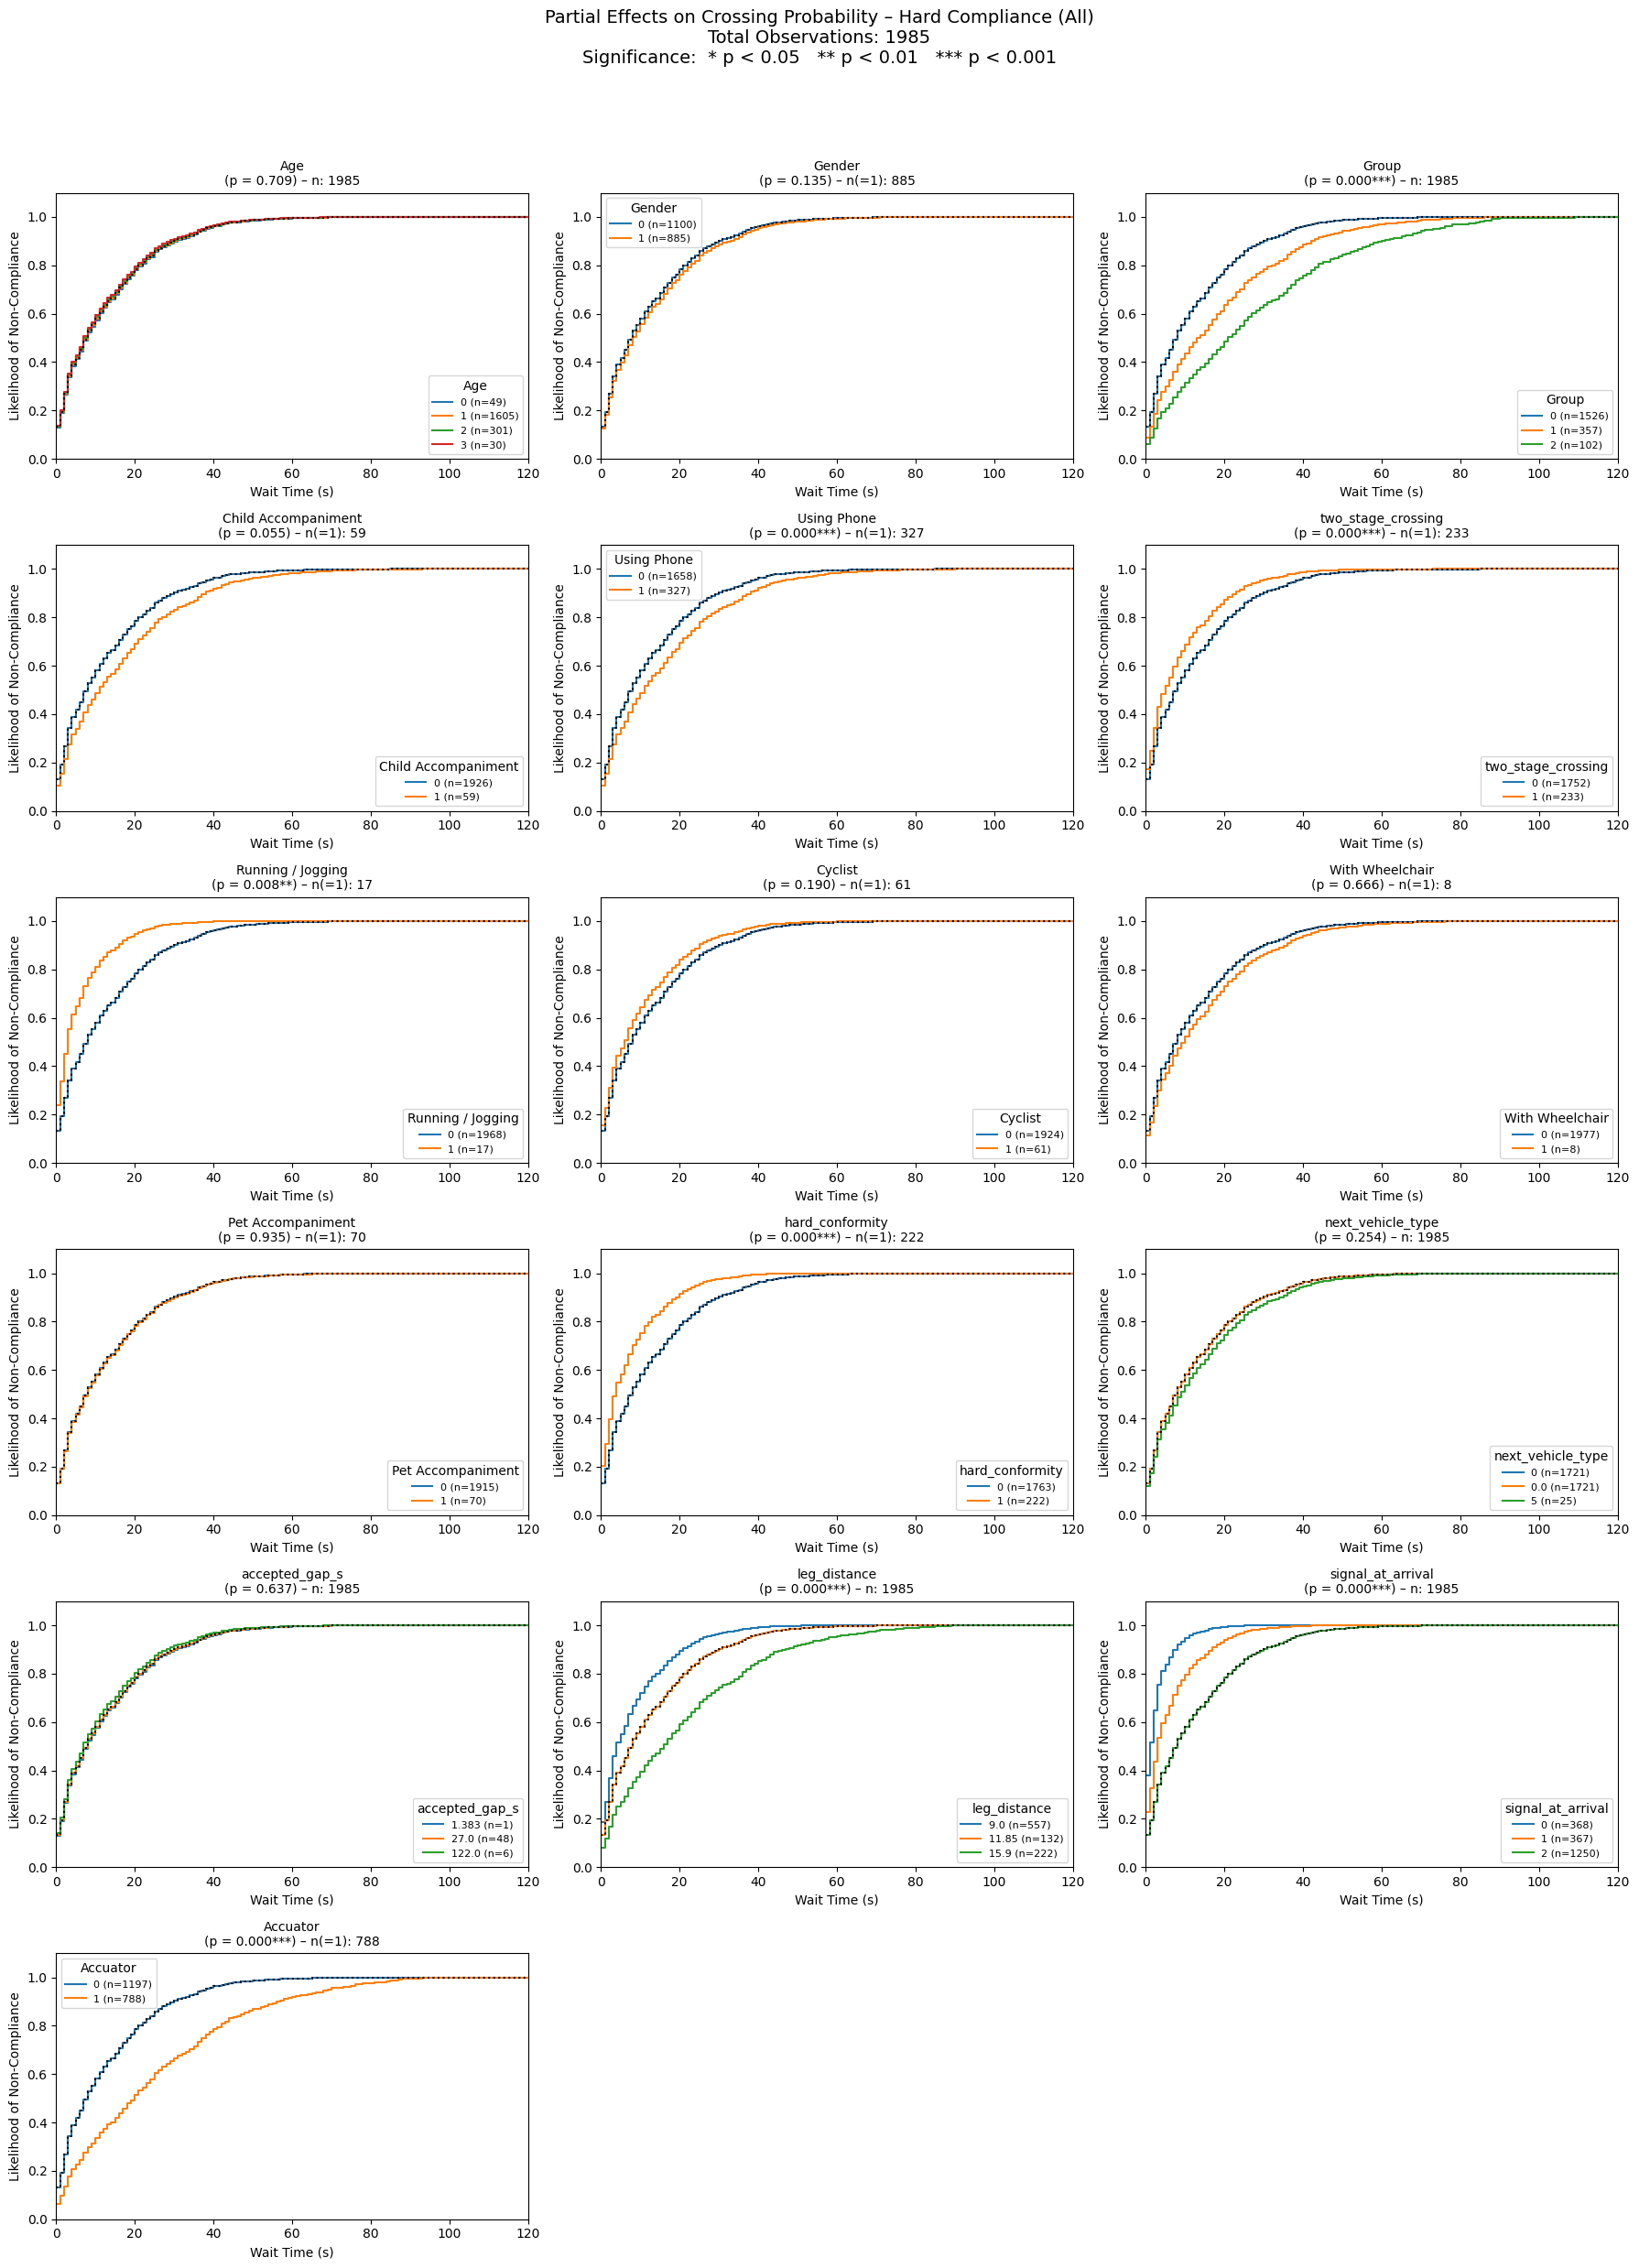

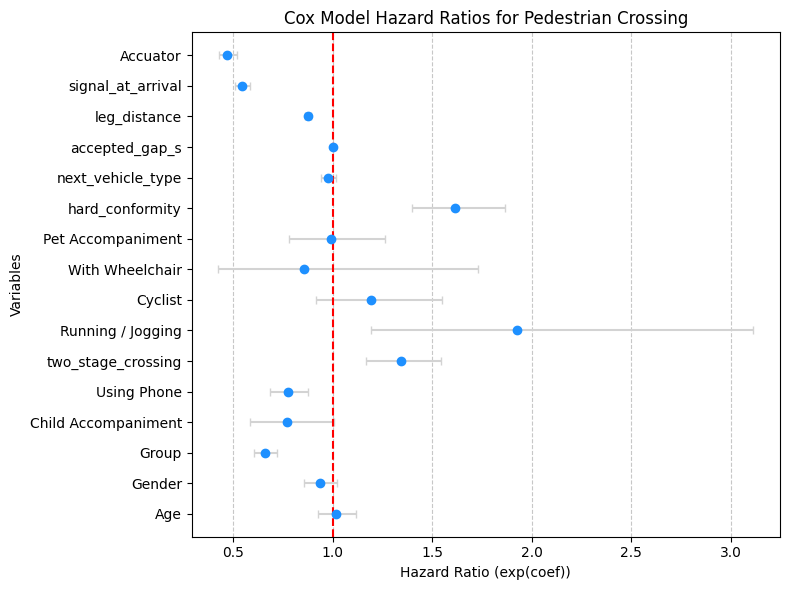

In [8]:
from lifelines import CoxPHFitter
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('/Users/cherrychoy/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/Honours Thesis/FINAL DATA/HAZARD_SINGLE_HARD_COMPLIANCE.csv')

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Strip spaces from string entries (if any)
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# ===================== 1. Filter for non-compliant pedestrians =====================
# df = df[df['hard_compliance'] == 1]

# ===================== 2. Define variables =====================
binary_cols = [
    "Accuator", "Gender", "Using Phone", "Child Accompaniment", "Pet Accompaniment",
    "Running / Jogging", "Cyclist", "With Wheelchair", 
    "With Pram",
    "two_stage_crossing", "hard_conformity", 
    "Accuator"
]

multi_cols = ["Age", "Group", "next_vehicle_type", 'signal_at_arrival']  # Multi-category

continuous_cols = ['wait_time_s', 
                   'time_to_next_vehicle_s', 
                   'accepted_gap_s', 
                   'leg_distance']

# Dependent variable (not used as covariate in hazard model)
dependent_var = 'hard_compliance'

# ===================== 3. Convert all relevant columns to numeric =====================
all_cols = binary_cols + multi_cols + continuous_cols + [dependent_var]

for col in all_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert safely

# --- Clean binary variables ---
for col in binary_cols:
    df[col] = df[col].round().clip(0, 1).astype("Int64")

# --- Clean multi-category variables ---
for col in multi_cols:
    df[col] = df[col].round().astype("Int64")

# --- Clean continuous variables ---
for col in continuous_cols:
    df[col] = df[col].astype(float)

# Drop missing rows
df = df.dropna(subset=all_cols)

df['Group'] = df['Group'].apply(lambda x: 2 if x >= 2 else x) # Combine groups 2 and above - clean up


# ===================== 4. Create event column =====================
# Event = pedestrian starts crossing (here we assume all eventually cross)
df['Event'] = 1

# ===================== 5. Define covariates for Cox model =====================
covariates = [
    'Age',
    'Gender', 
    'Group', 
    'Child Accompaniment',
    'Using Phone', 
    'two_stage_crossing', 
    'Running / Jogging',
    'Cyclist', 
    'With Wheelchair',
    'Pet Accompaniment', 
    'hard_conformity', 
    'next_vehicle_type', 
    'accepted_gap_s', 
    'leg_distance', 
    'signal_at_arrival', 
    'Accuator',

    # 'time_to_next_vehicle_s',  
    # 'With Pram', 
    # 'wait_time_s' (not unique)
]

# ===================== 6. Fit Cox Proportional Hazards Model =====================
cph = CoxPHFitter()
cph.fit(df[['wait_time_s', 'Event'] + covariates],
        duration_col='wait_time_s',
        event_col='Event')

# ===================== 7. View summary =====================
cph.print_summary()

def significance_stars(p):
    if p < 0.001: return "***"
    elif p < 0.01: return "**"
    elif p < 0.05: return "*"
    else: return ""
    
# # ===================== 8. Plot partial effects =====================
# # Example: effect of gap on crossing
# cph.plot_partial_effects_on_outcome(covariates='gap to next veh', values=[0,1])
# plt.show()
summary = cph.summary
predictors = cph.params_.index.tolist()

# Helper for significance stars
def significance_stars(p):
    if p < 0.001: return "***"
    elif p < 0.01: return "**"
    elif p < 0.05: return "*"
    else: return ""

# Set grid
n_vars = len(predictors)
cols = 3
rows = int(np.ceil(n_vars / cols))
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten()

# Total observations
n_obs = len(df)

for i, var in enumerate(predictors):
    unique_vals = sorted(df[var].dropna().unique())
    if len(unique_vals) > 5:
        vals_to_plot = [df[var].min(), df[var].median(), df[var].max()]
    else:
        vals_to_plot = unique_vals

    ax = axes[i]
    sub_ax = cph.plot_partial_effects_on_outcome(covariates=var, values=vals_to_plot, ax=ax)

    # Convert survival to crossing probability
    for line in sub_ax.get_lines():
        ydata = line.get_ydata()
        line.set_ydata(1 - ydata)

    # === Add counts to legend labels ===
    if len(vals_to_plot) <= 5:  # categorical / binary
        handles, labels = sub_ax.get_legend_handles_labels()
        new_labels = [f"{val} (n={(df[var] == val).sum()})" for val in vals_to_plot]
        sub_ax.legend(handles, new_labels, title=var, fontsize=8)

    # Occurrence count for variable (non-null count or n=1 for binary)
    if df[var].nunique() == 2 and set(df[var].dropna().unique()) <= {0, 1}:
        n_var = int((df[var] == 1).sum())
        count_label = f"n(=1): {n_var}"
    else:
        n_var = df[var].notna().sum()
        count_label = f"n: {n_var}"

    p_val = summary.loc[var, 'p']
    star = significance_stars(p_val)
    sub_ax.set_title(
        f"{var}\n(p = {p_val:.3f}{star}) – {count_label}",
        fontsize=10
    )
    sub_ax.set_xlabel("Wait Time (s)")
    sub_ax.set_ylabel("Likelihood of Non-Compliance")
    sub_ax.set_ylim(0, 1.1)
    sub_ax.set_xlim(0, 120)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add overall title and significance legend
fig.suptitle(
    f"Partial Effects on Crossing Probability – Hard Compliance (All)\n"
    f"Total Observations: {n_obs}\n"
    f"Significance:  * p < 0.05   ** p < 0.01   *** p < 0.001",
    fontsize=14, y=1.03
)

plt.tight_layout()
plt.show()

# ===================== 9. Plot Hazard Ratios with Confidence Intervals =====================
# Extract coefficients and confidence intervals
summary = cph.summary  # your CoxPHFitter model

# Only include covariates of interest
variables = summary.index
hr = summary['exp(coef)']
hr_lower = summary['exp(coef) lower 95%']
hr_upper = summary['exp(coef) upper 95%']

# Plot
plt.figure(figsize=(8,6))
plt.errorbar(hr, variables, xerr=[hr - hr_lower, hr_upper - hr], fmt='o', color='dodgerblue', ecolor='lightgray', capsize=3)
plt.axvline(x=1, color='red', linestyle='--')  # reference line HR=1
plt.xlabel("Hazard Ratio (exp(coef))")
plt.ylabel("Variables")
plt.title("Cox Model Hazard Ratios for Pedestrian Crossing")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()




In [ ]:
# Red dashed line at HR = 1 → no effect on hazard.
# Points to the right of 1 → factor increases hazard, pedestrian more likely to start crossing sooner.
# Points to the left of 1 → factor decreases hazard, pedestrian waits longer.
# Error bars → 95% confidence intervals; if they cross 1, the effect is not statistically significant.